# Simple EK60 Reader Example

This script demonstrates simple file reading and plotting of ek60
data.  Specifically, the script reads files passed to it, stores data in
a data object, retrieves values from the data, appends and inserts data from different sample
intervals, and uses matplotlib to plot multiple echograms.

## Setup

In [1]:
# -*- coding: utf-8 -*-
%matplotlib nbagg
%matplotlib  

from matplotlib.pyplot import figure, show, subplots_adjust, get_cmap
from echolab2.instruments import EK60
from echolab2.plotting.matplotlib import echogram

Using matplotlib backend: nbAgg


## Read in the data
First, lets read in some data. For this test, we purposely picked two files with the same channels, but 
with different pulse lengths and a different installation order.

In [2]:
# Create the list of input files.
# The descriptions below apply to reading these 2 files in the following order.
rawfiles = ['./data/EK60/DY1201_EK60-D20120214-T231011.raw',
            './data/EK60/DY1706_EK60-D20170609-T005736.raw']

# Create an instance of the EK60 instrument.
# This is the top level object used to interact with EK60 and  data sources.
ek60 = EK60.EK60()

# Use the read_raw method to read in a data file.
ek60.read_raw(rawfiles)

# Print some basic info about our object.  As you will see, 10 channels are 
# reported.  Each file has 5 channels, and are in fact, physically the same 
# hardware.  The reason there are 10 channels reported is because their 
# transceiver number in the ER60 software changed.
print(ek60)

<class 'echolab2.instruments.EK60.EK60'> at 0x124063fd0
    EK60 object contains data from 10 channels:
        1:GPT  18 kHz 009072034d45 3-1 ES18-11
        2:GPT  38 kHz 009072033fa2 1-1 ES38B
        3:GPT  70 kHz 009072058c6c 2-1 ES70-7C
        4:GPT 120 kHz 00907205794e 5-1 ES120-7C
        5:GPT 200 kHz 0090720346a8 4-1 ES200-7C
        6:GPT  18 kHz 009072034d45 1-1 ES18-11
        7:GPT  38 kHz 009072033fa2 2-1 ES38B
        8:GPT  70 kHz 009072058c6c 3-1 ES70-7C
        9:GPT 120 kHz 00907205794e 4-1 ES120-7C
        10:GPT 200 kHz 0090720346a8 5-1 ES200-7C
    data start time: 2012-02-14T23:10:11.298
      data end time: 2017-06-09T01:05:15.638
    number of pings: 899



## Parse the data
Now, parse the data for values you want to plot.  In this test, we retrieve data from the first and second channels of the 38kHZ frequency transciever and combine them into a raw data object.

In [3]:
# Get a reference to the RawData object that contains data from the first 38 kHz
# channel.
raw_data_38_1 = ek60.get_raw_data(channel_number=2)

# The sample data from channel 2 is contained in a 136x994 array.  The data was
# recorded with a 1024us transmit pulse length, which on the EK60 and related
# hardware results in a sample interval of 256us (sample interval = pulse
# length / 4).  The data were recorded in 2012.

print(raw_data_38_1)

<class 'echolab2.instruments.EK60.RawData'> at 0x12407b278
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B]
    frequency (first ping): 38000.0
 pulse length (first ping): 0.001024
           data start time: 2012-02-14T23:10:11.298
             data end time: 2012-02-14T23:10:51.642
           number of pings: 136
    power array dimensions: (136,994)
    angle array dimensions: (136,994)



In [4]:
# Also get a reference to the RawData object that contains data from the
# second 38 kHz channel.
raw_data_38_2 = ek60.get_raw_data(channel_number=7)

# Channel 7's sample data is a 763x1059 array recoded with a 512us pulse length
# resulting in a sample interval of 128us.  These data were recorded in 2017.

print(raw_data_38_2)

# Append the 2nd object's data to the first and print out the results.
raw_data_38_1.append(raw_data_38_2)

# The result of this append is that raw_data_38_1 now contains data from 899
# pings.  The first 136 pings are the 2012 data and the next 763 the 2017
# data.  The sample data arrays are 899x1059 and the object contains 2 unique
# sample intervals.

print(raw_data_38_1)

# Insert the 2nd object's data into the first at ping 50.
raw_data_38_1.insert(raw_data_38_2, ping_number=50)

# Now raw_data_38_1 contains 1662 pings. Pings 1-50 are from the 2012 data.
# Pings 51-813 are the 763 pings from the 2012 data. Pings 814-899 are the
# rest of the 2012 data and pings 900-1663 are a second copy of the 2017 data.

print(raw_data_38_1)

<class 'echolab2.instruments.EK60.RawData'> at 0x12407b358
                channel(s): [GPT  38 kHz 009072033fa2 2-1 ES38B]
    frequency (first ping): 38000.0
 pulse length (first ping): 0.000512
           data start time: 2017-06-09T00:57:36.074
             data end time: 2017-06-09T01:05:13.929
           number of pings: 763
    power array dimensions: (763,1059)
    angle array dimensions: (763,1059)

<class 'echolab2.instruments.EK60.RawData'> at 0x12407b278
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B]
    frequency (first ping): 38000.0
 pulse length (first ping): 0.001024
           data start time: 2012-02-14T23:10:11.298
             data end time: 2017-06-09T01:05:13.929
           number of pings: 899
    power array dimensions: (899,1059)
    angle array dimensions: (899,1059)

<class 'echolab2.instruments.EK60.RawData'> at 0x12407b278
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B, GPT  38 kHz 0090

## Plot Data
Using matplotlib, we can plot our data. But first, the data needs to get processed.

At this point, we have a 1662x1059 array with data recorded at two different sample intervals.  When we convert this data to return a ProcessedData object, we have to resample to a constant sample interval.  By default, the get_ methods will resample to the shortest sample interval (highest resolution) in the data that is being returned.  In our case, that will result in the 136 pings from 2012 recorded with a sample rate of 256us being resampled to 128us.

The the files were also recorded with slightly different sound speed values and we're not going to supply a constant sound speed (or any calibration values) to the get_power method so it will use the calibration parameter values from the RawData.  When no sound speed calibration data is provided, the get_* methods will resort to interpolating range using the sound speed that occurs most in the data (in other words, it interpolates the fewest pings it needs to).

When we request data using the get_ methods, we can provide a time range or ping range to return data from.  Providing no constraints on the range of data returned will return all of the data.  By default, the data will be in time order.  You can force the method to return data in ping order (the order it exists in the RawData object) by setting the time_order keyword to False.  Advanced indexing can be done outside of the get_ methods and passed into them using the return_indices keyword.

<IPython.core.display.Javascript object>


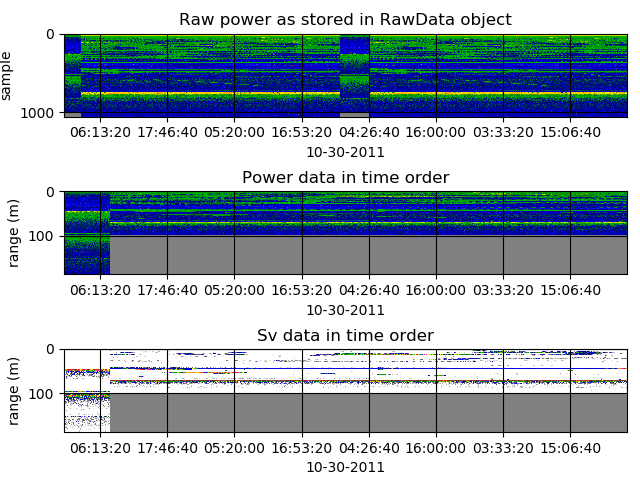

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x10cd828d0
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B]
                 frequency: 38000.0
           data start time: 2012-02-14T23:10:11.298
             data end time: 2017-06-09T01:05:13.929
            number of pings: 1662
            data attributes: ping_time (1662)
                            data (1662,1988)
                            range (1988)

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x10cd6ea58
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B]
                 frequency: 38000.0
           data start time: 2012-02-14T23:10:11.298
             data end time: 2017-06-09T01:05:13.929
            number of pings: 1662
            data attributes: ping_time (1662)
                            data (1662,1988)
      

In [5]:
# Create a matplotlib figure to plot raw and processed data on.
fig = figure()
# Set some properties for the sub plot layout.
subplots_adjust(left=0.1, bottom=0.1, right=0.98, top=.93, wspace=None, hspace=0.9)

# Create an axis for our raw data.
ax_1 = fig.add_subplot(3, 1, 1)
# Create an echogram to plot up the raw sample data.
echogram_2 = echogram.Echogram(ax_1, raw_data_38_1, 'power')
ax_1.set_title("Raw power as stored in RawData object")

#Now, process the data and plot the results.

# Call get_power to get a ProcessedData object that contains power data.  We
# provide no arguments so we get all pings ordered by time.
processed_power_1 = raw_data_38_1.get_power()
# That should be 1662 pings by 1988 samples.
print(processed_power_1)

# Create an axis for our processed power data in time order.
ax_2 = fig.add_subplot(3, 1, 2)
# Create an echogram which will display on our newly created axis.
echogram_2 = echogram.Echogram(ax_2, processed_power_1)
ax_2.set_title("Power data in time order")

# Now request Sv data in time order.
Sv = raw_data_38_1.get_Sv()
# This will also be 1662 pings by 1988 samples, but is Sv ordered by time.
print(Sv)

# Create another axis for our processed Sv data in time order.
ax_3 = fig.add_subplot(3, 1, 3)
# Create an echogram which will display on our newly created axis.
echogram_3 = echogram.Echogram(ax_3, Sv, threshold=[-70,-34])
ax_3.set_title("Sv data in time order")

# Show our figure.
show()

<IPython.core.display.Javascript object>


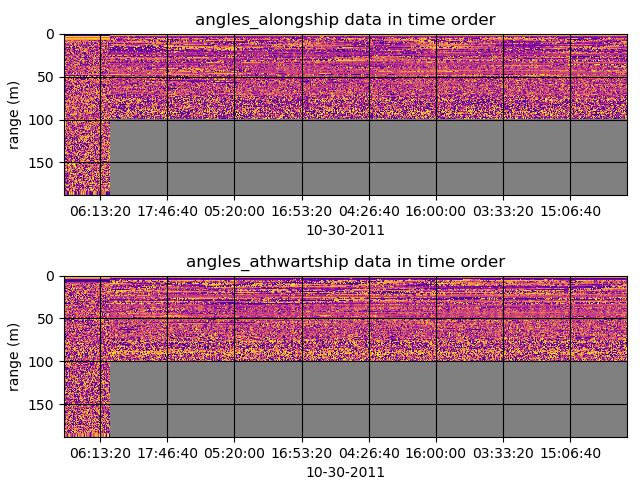

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x11cdd4828
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B]
                 frequency: 38000.0
           data start time: 2012-02-14T23:10:11.298
             data end time: 2017-06-09T01:05:13.929
            number of pings: 1662
            data attributes: ping_time (1662)
                            data (1662,1988)
                            range (1988)

<class 'echolab2.processing.processed_data.ProcessedData'> at 0x10e6892e8
                channel(s): [GPT  38 kHz 009072033fa2 1-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B, GPT  38 kHz 009072033fa2 2-1 ES38B]
                 frequency: 38000.0
           data start time: 2012-02-14T23:10:11.298
             data end time: 2017-06-09T01:05:13.929
            number of pings: 1662
            data attributes: ping_time (1662)
                            data (1662,1988)
      

In [6]:
# Create another matplotlib figure for displaying angle data.
fig = figure()
# Set some properties for the sub plot layout.
subplots_adjust(left=0.1, bottom=0.09, right=0.98, top=.93, wspace=None,
                hspace=0.5)

angle_cmap = get_cmap('plasma')

# Now request angles data in time order.
angles_along, angles_athwart = raw_data_38_1.get_physical_angles()
print(angles_along)
print(angles_athwart)

# Create an axis.
ax_1 = fig.add_subplot(2, 1, 1)
# Create an echogram which will display on our newly created axis.
echogram_3 = echogram.Echogram(ax_1, angles_along, cmap=angle_cmap)
ax_1.set_title("angles_alongship data in time order")

# Create another axis.
ax_2 = fig.add_subplot(2, 1, 2)
# Create an echogram which will display on our newly created axis.
echogram_3 = echogram.Echogram(ax_2, angles_athwart, cmap=angle_cmap)
ax_2.set_title("angles_athwartship data in time order")

# Show our figure.
show()


pass